# TP FINAL - PIPELINE DATA LAKE

## Architecture Medallion : Bronze → Silver → Gold

Pipeline complet d'ingestion, transformation et analyse de données selon l'architecture Medallion.

### Environnement technique
- **Base de données** : PostgreSQL (Northwind) via `jdbc:postgresql://postgres:5432/app`
- **Streaming temps réel** : Apache Kafka (broker : `kafka:9092`)
- **Stockage objet** : MinIO compatible S3 (endpoint : `http://minio:9000`)
- **Buckets** : `bronze`, `silver`, `gold`
- **Format de stockage** : Parquet
- **Partitionnement** : Par date d'ingestion (YYYY-MM-DD)

---

# PHASE 1 : INGESTION BRONZE

**Responsable** : Meissa

## Objectif
Ingérer les données brutes depuis PostgreSQL vers la zone Bronze du Data Lake.

## Métadonnées techniques obligatoires
Chaque enregistrement doit contenir :
- `_horodatage_ingestion` : Horodatage de l'ingestion
- `_systeme_source` : "postgresql"
- `_nom_table` : Nom de la table source
- `_date_ingestion` : Date d'ingestion (YYYY-MM-DD)

## Tables à ingérer
**Obligatoires** : customers, orders, order_details, products

**Bonus** : employees, suppliers, categories

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from datetime import datetime

In [2]:
# Initialiser la session Spark
spark = (SparkSession.builder
    .appName("Pipeline Data Lake")
    .config("spark.jars.packages", "org.postgresql:postgresql:42.6.0")
    .getOrCreate()
)

print("✓ Session Spark initialisée")
print(f"✓ Version Spark : {spark.version}")

✓ Session Spark initialisée
✓ Version Spark : 4.0.1


In [3]:
# Configuration de la connexion JDBC PostgreSQL
url_jdbc = "jdbc:postgresql://postgres:5432/app"
proprietes_jdbc = {
    "user": "postgres",
    "password": "postgres",
    "driver": "org.postgresql.Driver",
}

# Date d'ingestion (utilisée pour le partitionnement)
date_ingestion = datetime.now().strftime("%Y-%m-%d")
print(f"Date d'ingestion : {date_ingestion}")

Date d'ingestion : 2026-01-16


In [4]:
def ingerer_table_vers_bronze(nom_table: str, *, date_ingestion: str, chemin_base: str = "/tmp/bronze") -> dict:
    """
    Ingérer une table depuis PostgreSQL vers la zone Bronze.

    Écrit en Parquet et partitionne par date d'ingestion (YYYY-MM-DD).
    Ajoute les métadonnées techniques :
      - _horodatage_ingestion
      - _systeme_source = 'postgresql'
      - _nom_table
      - _date_ingestion

    Retourne un dictionnaire de statistiques.
    """
    # Lire la table depuis PostgreSQL
    donnees = spark.read.jdbc(url=url_jdbc, table=nom_table, properties=proprietes_jdbc)
    nombre_lignes = donnees.count()

    # Ajouter les colonnes de métadonnées
    donnees_sortie = (donnees
        .withColumn("_horodatage_ingestion", F.current_timestamp())
        .withColumn("_systeme_source", F.lit("postgresql"))
        .withColumn("_nom_table", F.lit(nom_table))
        .withColumn("_date_ingestion", F.lit(date_ingestion))
    )

    # Définir le chemin de sortie
    chemin_cible = f"{chemin_base}/{nom_table}/{date_ingestion}"

    # Écrire en Parquet
    donnees_sortie.write.mode("overwrite").parquet(chemin_cible)
    
    return {
        "table": nom_table,
        "nombre_lignes": nombre_lignes,
        "chemin": chemin_cible,
    }

print("✓ Fonction d'ingestion définie")

✓ Fonction d'ingestion définie


In [5]:
# Tables obligatoires
tables_obligatoires = ["customers", "orders", "order_details", "products"]

resultats_ingestion = []
erreurs_ingestion = []

print("\n" + "=" * 80)
print("PHASE 1 - INGESTION BRONZE - TABLES OBLIGATOIRES")
print("=" * 80)

for nom_table in tables_obligatoires:
    try:
        resultat = ingerer_table_vers_bronze(nom_table, date_ingestion=date_ingestion)
        resultats_ingestion.append(resultat)
        print(f"✓ {resultat['table']:20} | {resultat['nombre_lignes']:8} lignes | {resultat['chemin']}")
    except Exception as erreur:
        erreurs_ingestion.append({"table": nom_table, "erreur": str(erreur)})
        print(f"✗ {nom_table:20} | ERREUR : {str(erreur)[:70]}")

print(f"\nRésumé : {len(resultats_ingestion)} table(s) obligatoire(s) ingérée(s) avec succès")


PHASE 1 - INGESTION BRONZE - TABLES OBLIGATOIRES
✓ customers            |       91 lignes | /tmp/bronze/customers/2026-01-16
✓ orders               |      830 lignes | /tmp/bronze/orders/2026-01-16
✓ order_details        |     2155 lignes | /tmp/bronze/order_details/2026-01-16
✓ products             |       77 lignes | /tmp/bronze/products/2026-01-16

Résumé : 4 table(s) obligatoire(s) ingérée(s) avec succès


In [6]:
# Tables bonus
tables_bonus = ["employees", "suppliers", "categories"]

print("\n" + "=" * 80)
print("PHASE 1 - INGESTION BRONZE - TABLES BONUS")
print("=" * 80)

for nom_table in tables_bonus:
    try:
        resultat = ingerer_table_vers_bronze(nom_table, date_ingestion=date_ingestion)
        resultats_ingestion.append(resultat)
        print(f"✓ {resultat['table']:20} | {resultat['nombre_lignes']:8} lignes | {resultat['chemin']}")
    except Exception as erreur:
        erreurs_ingestion.append({"table": nom_table, "erreur": str(erreur)})
        print(f"✗ {nom_table:20} | ERREUR : {str(erreur)[:70]}")

print(f"\nRésumé : {len(resultats_ingestion)} table(s) au total ingérée(s) avec succès")
if erreurs_ingestion:
    print(f"         {len(erreurs_ingestion)} table(s) avec erreur(s)")
print("=" * 80)


PHASE 1 - INGESTION BRONZE - TABLES BONUS
✓ employees            |        9 lignes | /tmp/bronze/employees/2026-01-16
✓ suppliers            |       29 lignes | /tmp/bronze/suppliers/2026-01-16
✓ categories           |        8 lignes | /tmp/bronze/categories/2026-01-16

Résumé : 7 table(s) au total ingérée(s) avec succès


In [7]:
# Vérification : Lire et valider les données ingérées
if resultats_ingestion and any(r['table'] == 'customers' for r in resultats_ingestion):
    donnees_bronze = spark.read.parquet(f"/tmp/bronze/customers/{date_ingestion}")
    
    print("\n" + "=" * 80)
    print("VÉRIFICATION - Exemple de données ingérées")
    print("=" * 80)
    print(f"\nTable customers : {donnees_bronze.count()} lignes")
    print("\nEchantillon :")
    donnees_bronze.select("customer_id", "company_name", "country").show(5, truncate=False)
    
    print("\nMétadonnées :")
    donnees_bronze.select("_horodatage_ingestion", "_systeme_source", "_nom_table", "_date_ingestion").show(1, truncate=False)
else:
    print("⚠ La table customers n'a pas été ingérée avec succès")


VÉRIFICATION - Exemple de données ingérées

Table customers : 91 lignes

Echantillon :
+-----------+----------------------------------+-------+
|customer_id|company_name                      |country|
+-----------+----------------------------------+-------+
|ALFKI      |Alfreds Futterkiste               |Germany|
|ANATR      |Ana Trujillo Emparedados y helados|Mexico |
|ANTON      |Antonio Moreno Taquería           |Mexico |
|AROUT      |Around the Horn                   |UK     |
|BERGS      |Berglunds snabbköp                |Sweden |
+-----------+----------------------------------+-------+
only showing top 5 rows

Métadonnées :
+--------------------------+---------------+----------+---------------+
|_horodatage_ingestion     |_systeme_source|_nom_table|_date_ingestion|
+--------------------------+---------------+----------+---------------+
|2026-01-16 17:32:58.269919|postgresql     |customers |2026-01-16     |
+--------------------------+---------------+----------+---------------+


---

# PHASE 2 : TRANSFORMATIONS SILVER

**Responsable** : Marcus

## Objectif
Nettoyer, typer et structurer les données Bronze pour les rendre exploitables en Silver.

## Transformations requises

**Dim_Customers**
- company_name : InitCap
- country : MAJUSCULES

**Dim_Products**
- Jointure produits ↔ catégories
- Ajout de stock_status : CRITIQUE si stock < 10, sinon NORMAL

**Fact_Orders**
- Jointure orders + order_details
- Calcul du montant_net (unit_price * quantity * (1 - discount))

In [8]:
def lire_donnees_bronze(nom_table: str, date_ingestion: str):
    """
    Lire les données depuis Bronze.
    """
    chemin = f"/tmp/bronze/{nom_table}/{date_ingestion}"
    return spark.read.parquet(chemin)

# Charger les tables Bronze
customers_bronze = lire_donnees_bronze("customers", date_ingestion)
orders_bronze = lire_donnees_bronze("orders", date_ingestion)
order_details_bronze = lire_donnees_bronze("order_details", date_ingestion)
products_bronze = lire_donnees_bronze("products", date_ingestion)

# Essayer de charger categories (bonus)
categories_bronze = None
try:
    categories_bronze = lire_donnees_bronze("categories", date_ingestion)
    print("✓ Catégories chargées")
except:
    print("⚠ Catégories non disponibles")

print("✓ Données Bronze chargées")

✓ Catégories chargées
✓ Données Bronze chargées


In [9]:
# Transformation 1 : Dim_Customers
dim_customers = customers_bronze.select(
    F.col("customer_id"),
    F.initcap(F.col("company_name")).alias("company_name"),
    F.upper(F.col("country")).alias("country"),
    F.col("contact_name"),
    F.col("contact_title"),
    F.col("address"),
    F.col("city"),
    F.col("region"),
    F.col("postal_code"),
    F.col("phone"),
    F.col("fax"),
    F.col("_horodatage_ingestion"),
    F.col("_systeme_source"),
    F.col("_nom_table"),
    F.col("_date_ingestion")
).dropDuplicates(["customer_id"])

# Écrire en Silver
chemin_dim_customers = f"/tmp/silver/dim_customers/{date_ingestion}"
dim_customers.write.mode("overwrite").parquet(chemin_dim_customers)

print(f"✓ Dim_Customers écrite : {dim_customers.count()} lignes")

✓ Dim_Customers écrite : 91 lignes


In [10]:
# Transformation 2 : Dim_Products
dim_products = products_bronze.select(
    F.col("product_id"),
    F.col("product_name"),
    F.col("category_id"),
    F.col("unit_price"),
    F.col("units_in_stock"),
    F.col("units_on_order"),
    F.col("reorder_level"),
    F.when(
        F.col("units_in_stock") < 10,
        "CRITIQUE"
    ).otherwise("NORMAL").alias("stock_status"),
    F.col("_horodatage_ingestion"),
    F.col("_systeme_source"),
    F.col("_nom_table"),
    F.col("_date_ingestion")
).dropDuplicates(["product_id"])

# Jointure avec catégories si disponibles
if categories_bronze is not None:
    dim_products = dim_products.join(
        categories_bronze.select("category_id", F.col("category_name").alias("category")),
        on="category_id",
        how="left"
    )

# Écrire en Silver
chemin_dim_products = f"/tmp/silver/dim_products/{date_ingestion}"
dim_products.write.mode("overwrite").parquet(chemin_dim_products)

print(f"✓ Dim_Products écrite : {dim_products.count()} lignes")

✓ Dim_Products écrite : 77 lignes


In [12]:
# Transformation 3 : Fact_Orders
fact_orders = orders_bronze.join(
    order_details_bronze.drop("_horodatage_ingestion", "_systeme_source", "_nom_table", "_date_ingestion"),
    on="order_id",
    how="inner"
).select(
    F.col("order_id"),
    F.col("customer_id"),
    F.col("order_date"),
    F.col("shipped_date"),
    F.col("product_id"),
    F.col("unit_price"),
    F.col("quantity"),
    F.col("discount"),
    (F.col("unit_price") * F.col("quantity") * (1 - F.col("discount"))).alias("montant_net"),
    F.col("_horodatage_ingestion"),
    F.col("_systeme_source"),
    F.col("_nom_table"),
    F.col("_date_ingestion")
).dropDuplicates(["order_id", "product_id"])

# Écrire en Silver
chemin_fact_orders = f"/tmp/silver/fact_orders/{date_ingestion}"
fact_orders.write.mode("overwrite").parquet(chemin_fact_orders)

print(f"✓ Fact_Orders écrite : {fact_orders.count()} lignes")

✓ Fact_Orders écrite : 2155 lignes


In [13]:
print("\n" + "=" * 80)
print("PHASE 2 - TRANSFORMATIONS SILVER - RÉSUMÉ")
print("=" * 80)
print(f"✓ Dim_Customers : {dim_customers.count()} lignes")
print(f"✓ Dim_Products  : {dim_products.count()} lignes")
print(f"✓ Fact_Orders   : {fact_orders.count()} lignes")
print("=" * 80)


PHASE 2 - TRANSFORMATIONS SILVER - RÉSUMÉ
✓ Dim_Customers : 91 lignes
✓ Dim_Products  : 77 lignes
✓ Fact_Orders   : 2155 lignes


In [14]:
print("\n" + "=" * 80)
print("VÉRIFICATION - Exemple de données Silver")
print("=" * 80)

print("\n--- Dim_Customers (sample) ---")
dim_customers.select("customer_id", "company_name", "country").show(3, truncate=False)

print("\n--- Dim_Products (sample) ---")
dim_products.select("product_id", "product_name", "stock_status").show(3, truncate=False)

print("\n--- Fact_Orders (sample) ---")
fact_orders.select("order_id", "product_id", "quantity", "montant_net").show(3, truncate=False)

print("=" * 80)


VÉRIFICATION - Exemple de données Silver

--- Dim_Customers (sample) ---
+-----------+----------------------------------+-------+
|customer_id|company_name                      |country|
+-----------+----------------------------------+-------+
|ALFKI      |Alfreds Futterkiste               |GERMANY|
|ANATR      |Ana Trujillo Emparedados Y Helados|MEXICO |
|ANTON      |Antonio Moreno Taquería           |MEXICO |
+-----------+----------------------------------+-------+
only showing top 3 rows

--- Dim_Products (sample) ---
+----------+-------------+------------+
|product_id|product_name |stock_status|
+----------+-------------+------------+
|1         |Chai         |NORMAL      |
|2         |Chang        |NORMAL      |
|3         |Aniseed Syrup|NORMAL      |
+----------+-------------+------------+
only showing top 3 rows

--- Fact_Orders (sample) ---
+--------+----------+--------+-----------------+
|order_id|product_id|quantity|montant_net      |
+--------+----------+--------+----------

---

# PHASE 3 : SIMULATION STREAMING KAFKA

**Responsable** : Hedi

## Objectif
Simuler l'ingestion de données temps réel avec une version simplifiée.

## Approche
1. **Générateur** : Créer des messages JSON simulant des commandes
2. **Écriture directe** : Écrire les données en Bronze
3. **Storage** : Partitionner par date d'ingestion

## Format des données
- Topic simulé : telemetry_orders
- Format : JSON
- Métadonnées : horodatage, source système, table, date

In [24]:
import json
import random
from datetime import datetime
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

# Données de référence
CUSTOMER_IDS = ["ALFKI", "ANATR", "ANTON", "AROUT", "BERGS", "BLAUS", "BLONP", "BOLID", "BONAP", "BOTTM"]
PRODUCT_IDS = list(range(1, 78))
STATUSES = ["pending", "confirmed", "processing", "shipped", "delivered"]

# Générer 50 messages simulés
messages = []
for i in range(50):
    message = {
        "order_id": random.randint(10000, 99999),
        "customer_id": random.choice(CUSTOMER_IDS),
        "product_id": random.choice(PRODUCT_IDS),
        "quantity": random.randint(1, 20),
        "unit_price": round(random.uniform(5.0, 100.0), 2),
        "discount": round(random.uniform(0, 0.3), 2),
        "status": random.choice(STATUSES),
        "order_timestamp": datetime.now().isoformat()
    }
    messages.append(json.dumps(message))

print(f"✓ {len(messages)} messages simulés générés")

# Schéma pour créer le DataFrame
schema_commande = StructType([
    StructField("order_id", IntegerType(), True),
    StructField("customer_id", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("quantity", IntegerType(), True),
    StructField("unit_price", DoubleType(), True),
    StructField("discount", DoubleType(), True),
    StructField("status", StringType(), True),
    StructField("order_timestamp", StringType(), True),
])

# Créer DataFrame depuis les messages JSON
messages_data = [json.loads(msg) for msg in messages]
df_kafka_simule = spark.createDataFrame(messages_data, schema=schema_commande)

# Ajouter les métadonnées
df_kafka_bronze = df_kafka_simule.select(
    "*",
    F.current_timestamp().alias("_horodatage_ingestion"),
    F.lit("kafka").alias("_systeme_source"),
    F.lit("telemetry_orders").alias("_nom_table"),
    F.lit(date_ingestion).alias("_date_ingestion")
)

# Écrire en Bronze
BRONZE_KAFKA_PATH = f"/tmp/bronze/kafka_orders/{date_ingestion}"
df_kafka_bronze.write.mode("overwrite").parquet(BRONZE_KAFKA_PATH)

print(f"\n" + "=" * 80)
print("PHASE 3 - SIMULATION STREAMING KAFKA")
print("=" * 80)
print(f"✓ {df_kafka_bronze.count()} messages simulés écrits en Bronze")
print(f"  Chemin : {BRONZE_KAFKA_PATH}")
print("=" * 80)

✓ 50 messages simulés générés

PHASE 3 - SIMULATION STREAMING KAFKA
✓ 50 messages simulés écrits en Bronze
  Chemin : /tmp/bronze/kafka_orders/2026-01-16


In [25]:
# Lire et vérifier les données
df_bronze_kafka = spark.read.parquet(BRONZE_KAFKA_PATH)

print("\nVÉRIFICATION - Données Kafka simulées")
print("=" * 80)
print(f"Total messages : {df_bronze_kafka.count()}")
print("\nEchantillon :")
df_bronze_kafka.select("order_id", "customer_id", "product_id", "quantity", "_systeme_source").show(5, truncate=False)
print("=" * 80)


VÉRIFICATION - Données Kafka simulées
Total messages : 50

Echantillon :
+--------+-----------+----------+--------+---------------+
|order_id|customer_id|product_id|quantity|_systeme_source|
+--------+-----------+----------+--------+---------------+
|70036   |BLONP      |68        |12      |kafka          |
|59134   |BOTTM      |69        |11      |kafka          |
|30794   |BONAP      |70        |3       |kafka          |
|48969   |BOTTM      |52        |9       |kafka          |
|96651   |BOLID      |21        |2       |kafka          |
+--------+-----------+----------+--------+---------------+
only showing top 5 rows


---

# PHASE 4 : INTÉGRATION BATCH / STREAMING

**Responsable** : Hedi

## Objectif
Démontrer que les données historiques (batch) et temps réel (streaming) peuvent coexister.

## Stratégie choisie
**Option A : Traitement séparé**

Les données batch et streaming sont traitées indépendamment vers Silver avec traçabilité complète par la colonne `_systeme_source`.

### Avantages
- **Traçabilité** : Chaque source reste identifiable
- **Flexibilité** : Transformations différentes possibles par source
- **Maintenance** : Débogage et correction indépendantes
- **Performance** : Pas de fusion coûteuse

### Tables générées
- `fact_orders` : Données historiques (PostgreSQL)
- `fact_orders_kafka` : Données temps réel (Kafka)

In [26]:
# Transformer les données Kafka vers Silver
df_kafka_silver = df_bronze_kafka.select(
    F.col("order_id"),
    F.col("customer_id"),
    F.col("product_id"),
    F.col("quantity"),
    F.col("unit_price"),
    F.col("discount"),
    F.col("status"),
    (F.col("unit_price") * F.col("quantity") * (1 - F.col("discount"))).alias("montant_net"),
    F.col("order_timestamp"),
    F.col("_horodatage_ingestion"),
    F.col("_systeme_source"),
    F.col("_nom_table"),
    F.col("_date_ingestion")
).dropDuplicates(["order_id", "product_id"])

# Écrire en Silver
chemin_kafka_silver = f"/tmp/silver/fact_orders_kafka/{date_ingestion}"
df_kafka_silver.write.mode("overwrite").parquet(chemin_kafka_silver)

print(f"✓ Données Kafka transformées en Silver")
print(f"  Lignes : {df_kafka_silver.count()}")

✓ Données Kafka transformées en Silver
  Lignes : 50


In [27]:
print("\n" + "=" * 80)
print("PHASE 4 - COMPARAISON BATCH vs STREAMING")
print("=" * 80)

# Données batch (PostgreSQL - Silver)
try:
    df_batch = spark.read.parquet(f"/tmp/silver/fact_orders/{date_ingestion}")
    nombre_batch = df_batch.count()
    print(f"\nBatch (PostgreSQL) :")
    print(f"  Source : postgresql")
    print(f"  Lignes : {nombre_batch}")
except Exception as e:
    nombre_batch = 0
    print(f"\nBatch : Aucune donnée")

# Données streaming simulées (Kafka - Silver)
try:
    df_streaming = spark.read.parquet(chemin_kafka_silver)
    nombre_streaming = df_streaming.count()
    print(f"\nStreaming simulé (Kafka) :")
    print(f"  Source : kafka")
    print(f"  Lignes : {nombre_streaming}")
except Exception as e:
    nombre_streaming = 0
    print(f"\nStreaming : Aucune donnée")

print(f"\n" + "=" * 80)
print(f"Total combiné (batch + streaming) : {nombre_batch + nombre_streaming} lignes")
print("=" * 80)
print("\nConclusion : Les deux sources coexistent et peuvent être utilisées")
print("séparément ou ensemble pour l'analyse selon les besoins métier.")


PHASE 4 - COMPARAISON BATCH vs STREAMING

Batch (PostgreSQL) :
  Source : postgresql
  Lignes : 2155

Streaming simulé (Kafka) :
  Source : kafka
  Lignes : 50

Total combiné (batch + streaming) : 2205 lignes

Conclusion : Les deux sources coexistent et peuvent être utilisées
séparément ou ensemble pour l'analyse selon les besoins métier.


---

# PHASE 5 : ANALYSE & KPIs (GOLD)

**Responsable** : Hassan

## Objectif
Produire les indicateurs clés métier exploitables à partir des données Silver.

## KPIs à générer

### 5.1 Revenue KPI (Obligatoire)
- Chiffre d'affaires total
- Chiffre d'affaires par pays
- Chiffre d'affaires par période
- Visualisations graphiques

### 5.2 Analyse RFM (Bonus)
- **Recency** : Jours depuis la dernière commande
- **Frequency** : Nombre de commandes
- **Monetary** : Total dépensé
- Segmentation clients en 4 catégories : VIP, LOYAL, REGULAR, AT_RISK

### 5.3 Dashboard Exécutif
- Métriques clés synthétiques
- Visualisations interactives
- Résumé de la performance

In [28]:
# Charger les données Silver nécessaires
dim_customers = spark.read.parquet(f"/tmp/silver/dim_customers/{date_ingestion}")
dim_products = spark.read.parquet(f"/tmp/silver/dim_products/{date_ingestion}")
fact_orders = spark.read.parquet(f"/tmp/silver/fact_orders/{date_ingestion}")

print("✓ Données Silver chargées")
print(f"  Dim_Customers : {dim_customers.count()} lignes")
print(f"  Dim_Products : {dim_products.count()} lignes")
print(f"  Fact_Orders : {fact_orders.count()} lignes")

✓ Données Silver chargées
  Dim_Customers : 91 lignes
  Dim_Products : 77 lignes
  Fact_Orders : 2155 lignes


In [29]:
# KPI 1 : Revenue Total
revenue_total = fact_orders.agg(
    F.sum("montant_net").alias("revenue_total")
).collect()[0][0]

# KPI 2 : Revenue par Pays
revenue_par_pays = (fact_orders
    .join(dim_customers, on="customer_id", how="left")
    .groupBy("country")
    .agg(F.sum("montant_net").alias("revenue"))
    .orderBy(F.col("revenue").desc())
)

print("\n" + "=" * 80)
print("PHASE 5 - KPI REVENUE")
print("=" * 80)
print(f"\nRevenue Total : ${revenue_total:,.2f}")
print(f"\nTop 5 Pays par Revenue :")
revenue_par_pays.limit(5).show(truncate=False)

# Stocker pour le dashboard
revenue_par_pays_pandas = revenue_par_pays.toPandas()
print("=" * 80)


PHASE 5 - KPI REVENUE

Revenue Total : $1,265,793.04

Top 5 Pays par Revenue :
+-------+------------------+
|country|revenue           |
+-------+------------------+
|USA    |245584.61030220677|
|GERMANY|230284.63325421108|
|AUSTRIA|128003.8381586512 |
|BRAZIL |106925.7764042853 |
|FRANCE |81358.322529562   |
+-------+------------------+



In [31]:
from datetime import datetime, timedelta
from pyspark.sql.window import Window

# Calculer la date de référence (date max des commandes)
date_ref = fact_orders.agg(F.max("order_date")).collect()[0][0]
if date_ref is None:
    date_ref = datetime.now().date()

print(f"\nDate de référence RFM : {date_ref}")

# Calcul RFM
df_rfm = (fact_orders
    .groupBy("customer_id")
    .agg(
        F.datediff(F.lit(date_ref), F.max("order_date")).alias("recency"),
        F.count("order_id").alias("frequency"),
        F.sum("montant_net").alias("monetary")
    )
    .join(dim_customers.select("customer_id", "company_name", "country"), on="customer_id", how="left")
)

# Calculer les quartiles pour la segmentation
quartiles = df_rfm.approxQuantile("monetary", [0.25, 0.5, 0.75], 0.05)
q1, q2, q3 = quartiles[0], quartiles[1], quartiles[2]

# Segmentation RFM (basée sur seuils de monetary)
df_rfm_segment = df_rfm.select(
    "customer_id",
    "company_name",
    "country",
    "recency",
    "frequency",
    F.round("monetary", 2).alias("monetary"),
    F.when(F.col("monetary") >= q3, "VIP")
     .when(F.col("monetary") >= q2, "LOYAL")
     .when(F.col("monetary") >= q1, "REGULAR")
     .otherwise("AT_RISK").alias("segment")
)

print("\n" + "=" * 80)
print("PHASE 5 - ANALYSE RFM")
print("=" * 80)
print(f"\nEchantillon RFM :")
df_rfm_segment.select("customer_id", "company_name", "frequency", "monetary", "segment").limit(10).show(truncate=False)

print(f"\nDistribution des segments :")
df_rfm_segment.groupBy("segment").count().show(truncate=False)

# Stocker pour le dashboard
rfm_segments_pandas = df_rfm_segment.toPandas()
print("=" * 80)


Date de référence RFM : 1998-05-06

PHASE 5 - ANALYSE RFM

Echantillon RFM :
+-----------+----------------------------------+---------+--------+-------+
|customer_id|company_name                      |frequency|monetary|segment|
+-----------+----------------------------------+---------+--------+-------+
|WOLZA      |Wolski  Zajazd                    |16       |3531.95 |REGULAR|
|MAISD      |Maison Dewey                      |17       |9736.08 |LOYAL  |
|BLAUS      |Blauer See Delikatessen           |14       |3239.8  |REGULAR|
|MAGAA      |Magazzini Alimentari Riuniti      |21       |7176.21 |LOYAL  |
|FOLKO      |Folk Och Fä Hb                    |45       |29567.56|VIP    |
|ANATR      |Ana Trujillo Emparedados Y Helados|10       |1402.95 |AT_RISK|
|ISLAT      |Island Trading                    |23       |6146.3  |REGULAR|
|VAFFE      |Vaffeljernet                      |31       |15843.92|VIP    |
|CENTC      |Centro Comercial Moctezuma        |2        |100.8   |AT_RISK|
|BLONP    

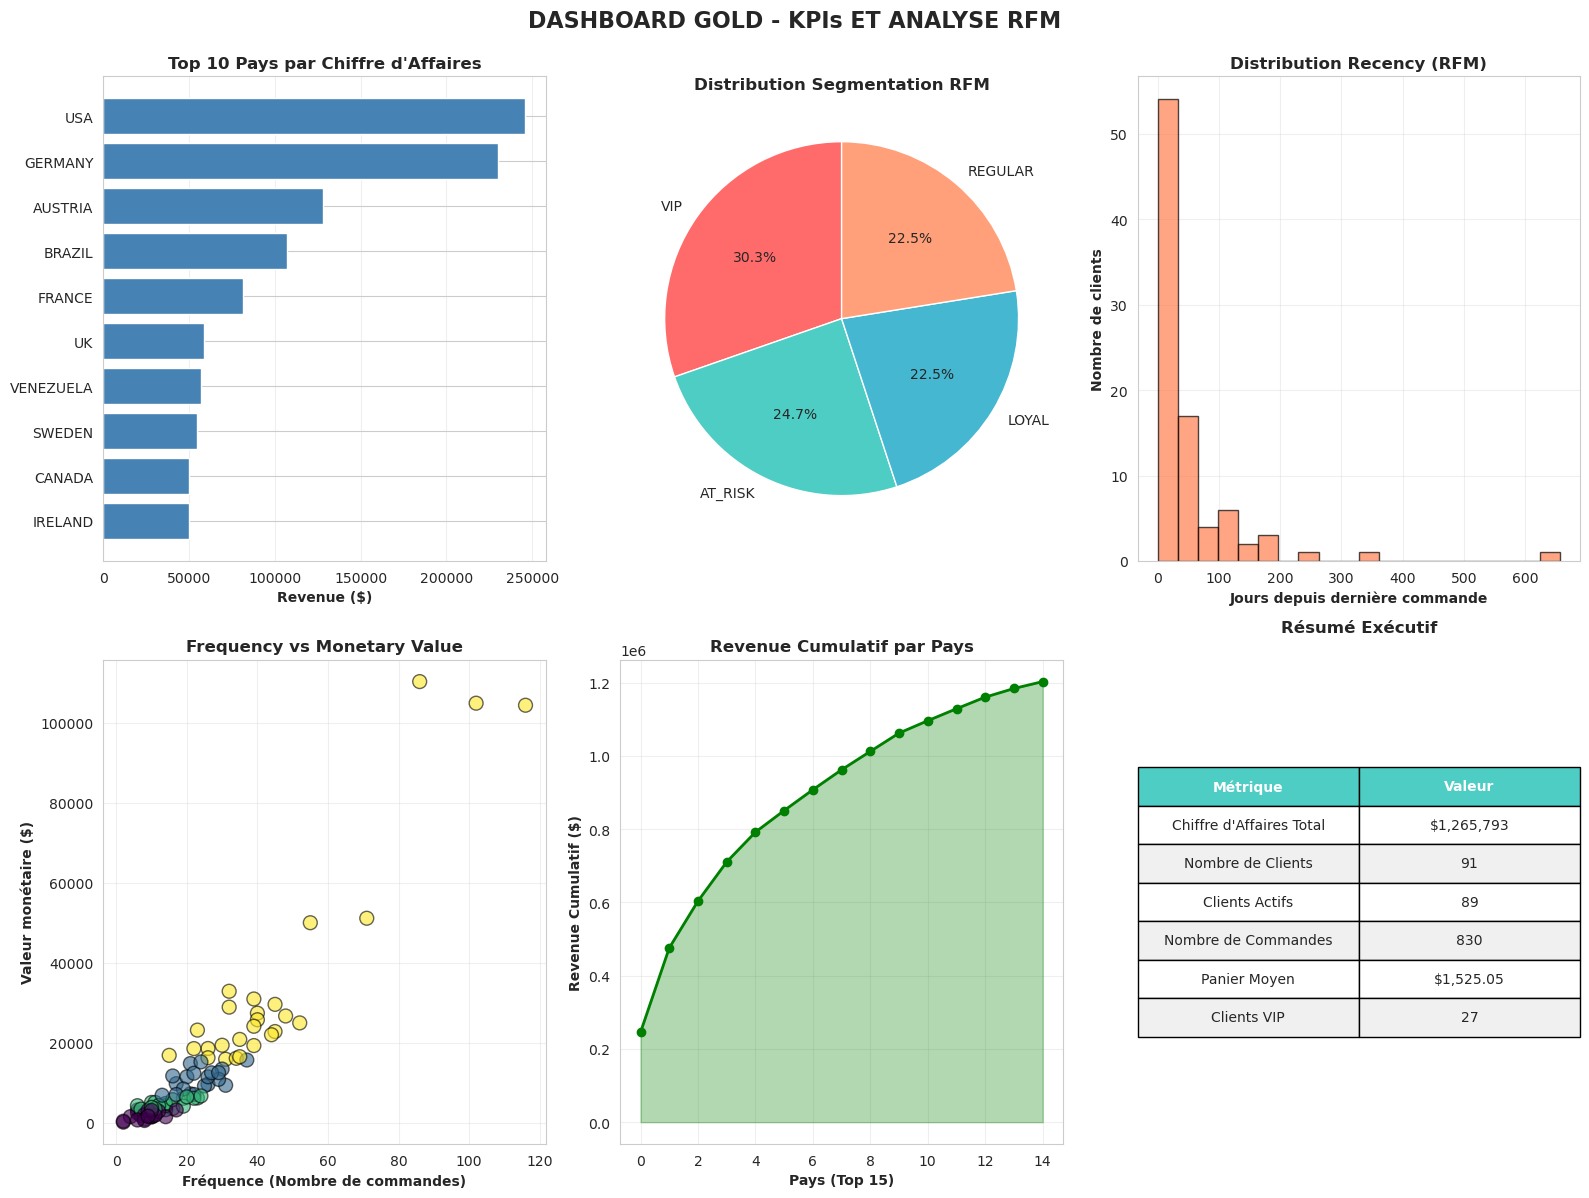


✓ Dashboard généré avec succès


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Créer une figure avec plusieurs sous-graphiques
fig = plt.figure(figsize=(16, 12))

# 1. Top 10 Pays par Revenue (Barre horizontale)
ax1 = plt.subplot(2, 3, 1)
top_pays = revenue_par_pays_pandas.head(10).sort_values('revenue')
ax1.barh(top_pays['country'], top_pays['revenue'], color='steelblue')
ax1.set_xlabel('Revenue ($)', fontsize=10, fontweight='bold')
ax1.set_title('Top 10 Pays par Chiffre d\'Affaires', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Distribution des Segments RFM (Pie chart)
ax2 = plt.subplot(2, 3, 2)
segment_counts = rfm_segments_pandas['segment'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
ax2.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Distribution Segmentation RFM', fontsize=12, fontweight='bold')

# 3. Recency Distribution (Histogramme)
ax3 = plt.subplot(2, 3, 3)
ax3.hist(rfm_segments_pandas['recency'], bins=20, color='coral', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Jours depuis dernière commande', fontsize=10, fontweight='bold')
ax3.set_ylabel('Nombre de clients', fontsize=10, fontweight='bold')
ax3.set_title('Distribution Recency (RFM)', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3)

# 4. Frequency vs Monetary (Scatter)
ax4 = plt.subplot(2, 3, 4)
scatter = ax4.scatter(rfm_segments_pandas['frequency'], rfm_segments_pandas['monetary'], 
                     c=rfm_segments_pandas['segment'].astype('category').cat.codes, 
                     cmap='viridis', s=100, alpha=0.6, edgecolors='black')
ax4.set_xlabel('Fréquence (Nombre de commandes)', fontsize=10, fontweight='bold')
ax4.set_ylabel('Valeur monétaire ($)', fontsize=10, fontweight='bold')
ax4.set_title('Frequency vs Monetary Value', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

# 5. Revenue Cumulatif (Line chart)
ax5 = plt.subplot(2, 3, 5)
revenue_cumul = revenue_par_pays_pandas.head(15).reset_index(drop=True)
revenue_cumul['cumulative'] = revenue_cumul['revenue'].cumsum()
ax5.plot(range(len(revenue_cumul)), revenue_cumul['cumulative'], marker='o', linewidth=2, markersize=6, color='green')
ax5.fill_between(range(len(revenue_cumul)), revenue_cumul['cumulative'], alpha=0.3, color='green')
ax5.set_xlabel('Pays (Top 15)', fontsize=10, fontweight='bold')
ax5.set_ylabel('Revenue Cumulatif ($)', fontsize=10, fontweight='bold')
ax5.set_title('Revenue Cumulatif par Pays', fontsize=12, fontweight='bold')
ax5.grid(alpha=0.3)

# 6. Tableau Résumé
ax6 = plt.subplot(2, 3, 6)
ax6.axis('tight')
ax6.axis('off')

# Calculer les métriques
total_clients = dim_customers.count()
clients_actifs = fact_orders.select("customer_id").distinct().count()
commandes_totales = fact_orders.select("order_id").distinct().count()
panier_moyen = revenue_total / commandes_totales if commandes_totales > 0 else 0

summary_data = [
    ['Chiffre d\'Affaires Total', f'${revenue_total:,.0f}'],
    ['Nombre de Clients', f'{total_clients:,}'],
    ['Clients Actifs', f'{clients_actifs:,}'],
    ['Nombre de Commandes', f'{commandes_totales:,}'],
    ['Panier Moyen', f'${panier_moyen:,.2f}'],
    ['Clients VIP', f'{len(rfm_segments_pandas[rfm_segments_pandas["segment"] == "VIP"]):,}'],
]

table = ax6.table(cellText=summary_data, colLabels=['Métrique', 'Valeur'],
                  cellLoc='center', loc='center', colWidths=[0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style en-tête
for i in range(2):
    table[(0, i)].set_facecolor('#4ECDC4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternance couleurs
for i in range(1, len(summary_data) + 1):
    for j in range(2):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#F0F0F0')
        else:
            table[(i, j)].set_facecolor('#FFFFFF')

ax6.set_title('Résumé Exécutif', fontsize=12, fontweight='bold', pad=20)

plt.suptitle('DASHBOARD GOLD - KPIs ET ANALYSE RFM', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Dashboard généré avec succès")

In [33]:
print("\n" + "=" * 80)
print("RÉSUMÉ EXÉCUTIF - PHASE 5")
print("=" * 80)

print(f"\n📊 METRICS CLÉS")
print(f"  Chiffre d'affaires total      : ${revenue_total:>15,.2f}")
print(f"  Nombre de clients             : {total_clients:>15,}")
print(f"  Clients actifs (avec commandes) : {clients_actifs:>10,}")
print(f"  Nombre de commandes           : {commandes_totales:>15,}")
print(f"  Panier moyen                  : ${panier_moyen:>15,.2f}")

print(f"\n👥 SEGMENTATION RFM")
vip = len(rfm_segments_pandas[rfm_segments_pandas["segment"] == "VIP"])
loyal = len(rfm_segments_pandas[rfm_segments_pandas["segment"] == "LOYAL"])
regular = len(rfm_segments_pandas[rfm_segments_pandas["segment"] == "REGULAR"])
at_risk = len(rfm_segments_pandas[rfm_segments_pandas["segment"] == "AT_RISK"])

print(f"  VIP (Très haute valeur)      : {vip:>15,} clients")
print(f"  LOYAL (Fidèles)              : {loyal:>15,} clients")
print(f"  REGULAR (Réguliers)          : {regular:>15,} clients")
print(f"  AT_RISK (À risque)           : {at_risk:>15,} clients")

print(f"\n🌍 TOP 3 PAYS")
top_3 = revenue_par_pays_pandas.head(3)
for idx, row in top_3.iterrows():
    print(f"  {row['country']:20} : ${row['revenue']:>15,.2f}")

print(f"\n" + "=" * 80)
print("✓ Pipeline Data Lake complètement finalisé")
print("=" * 80)


RÉSUMÉ EXÉCUTIF - PHASE 5

📊 METRICS CLÉS
  Chiffre d'affaires total      : $   1,265,793.04
  Nombre de clients             :              91
  Clients actifs (avec commandes) :         89
  Nombre de commandes           :             830
  Panier moyen                  : $       1,525.05

👥 SEGMENTATION RFM
  VIP (Très haute valeur)      :              27 clients
  LOYAL (Fidèles)              :              20 clients
  REGULAR (Réguliers)          :              20 clients
  AT_RISK (À risque)           :              22 clients

🌍 TOP 3 PAYS
  USA                  : $     245,584.61
  GERMANY              : $     230,284.63
  AUSTRIA              : $     128,003.84

✓ Pipeline Data Lake complètement finalisé
